# Test the optimal $n,k$ and their corresponding partial derivatives

In [35]:
import numpy as np

# computation scenario
B = 1
# input shape
C_i, H_i, W_i = 64, 224, 224
# output shape
C_o, H_o, W_o = 64, 224, 224

kernel_size, stride, padding = 3, 1, 1

conv_params = (B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding)

scale = 100000  # shape (scale, n) for generating random variables, n values per group


# rate parameter and shift parameter, should be set with proper values
#  master
mu_m, theta_m = 5e9, 5e-9
# #  worker: 4 CPU cores, 1.5 GHz = 1.5 * 10^9 Hz, maximum 10 MB/s
# #  - mu for computation: floating point operation per second
# #  - theta for computation: seconds per floating point operation
# #  - mu for transmission: bytes per second (B/s)
# #  - theta for computation: seconds per byte (s/B)

# tr parameters
# mus_tr = [1e5, 1e8, 1e7]
# thetas_tr = [1e-5, 1e-8, 1e-9]
mus_tr = [1e5, 1e6, 1e7]
thetas_tr = [1e-7, 1e-8, 1e-9]
# mu_theta_tr_pairs = [(mus_tr[0], thetas_tr[1]), (mus_tr[2], thetas_tr[1]), (mus_tr[1], thetas_tr[1]), (mus_tr[1], thetas_tr[0]), (mus_tr[1], thetas_tr[2])]
# mu_theta_tr_pairs_str = [('10^5', '10^{-8}'), ('10^7', '10^{-8}'), ('10^6', '10^{-8}'), ('10^6', '10^{-6}'), ('10^6', '10^{-10}')]
mu_theta_tr_pairs = [(mus_tr[0], thetas_tr[1]), (mus_tr[1], thetas_tr[0]), (mus_tr[1], thetas_tr[1]), (mus_tr[1], thetas_tr[2]), (mus_tr[2], thetas_tr[1])]
mu_theta_tr_pairs_str = [('10^5', '10^{-8}'), ('10^6', '10^{-6}'), ('10^6', '10^{-8}'), ('10^6', '10^{-10}'), ('10^7', '10^{-8}')]

# mu_theta_tr_pairs = mu_theta_tr_pairs
# mu_theta_tr_pairs_str = mu_theta_tr_pairs_str

# cmp parameters
mus_cmp = [1e7, 1e8, 1e9]
thetas_cmp = [1e-7, 1e-8, 1e-9]
# mu_theta_cmp_pairs = [(mus_cmp[0], thetas_cmp[1]), (mus_cmp[2], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[0]), (mus_cmp[1], thetas_cmp[2])]
# mu_theta_cmp_pairs_str = [('10^7', '10^{-8}'), ('10^9', '10^{-8}'), ('10^8', '10^{-8}'), ('10^8', '10^{-7}'), ('10^8', '10^{-9}')]
mu_theta_cmp_pairs = [(mus_cmp[0], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[0]), (mus_cmp[1], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[2]), (mus_cmp[2], thetas_cmp[1])]
mu_theta_cmp_pairs_str = [('10^7', '10^{-8}'), ('10^8', '10^{-7}'), ('10^8', '10^{-8}'), ('10^8', '10^{-9}'), ('10^9', '10^{-8}')]

mu_tr = mus_tr[1]
theta_tr = thetas_tr[1]
mu_cmp = 1e9
theta_cmp = 1e-9

In [36]:
from scipy.optimize import minimize, Bounds

def estimated_latency_n_1(system_params, conv_params, n, k):  ### 和上面的latency式子不等价？至少不至于差这么多吧 今天把这个gap找到
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o]) # 这个用int32表示会溢出了
    # print(Iov, IW, O, Nc)  # 这里暂时没bug了

    h_1 = np.prod([2.0,Iov,1/mu_m+theta_m])
    h_2 = np.prod([2.0,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    # L = np.prod([h_1,k,n])+np.prod([h_2,n]+np.prod([h_3,k]))+np.prod([h_4,n/k])+np.prod([h_5,1/])
    Lnk = h_1*k*n + h_2*n + h_3*k + h_4*n/k + h_5/k + h_6*n*np.log(n/(n-k)) + h_7*n/k*np.log(n/(n-k)) + h_8/k*np.log(n/(n-k))
    # 之前h6那里写成了/np.log...，所以还是有点差，现在应该跟另一个总时延估计一样了
    return Lnk

def estimated_derivative_k(system_params, conv_params, n, k):  # 算的不对啊？最优k不应该偏导接近0吗？
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])
    # print(h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8)

    dk = n*h_1 + h_3 - (n*h_4 + h_5)/k**2 + n*h_6/(n-k) + (n*h_7 + h_8)*(-1/k**2 * np.log(n/(n-k)) + 1/k*(n-k))
    return dk

def estimated_derivative_n(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    dn = h_1*k + h_2 + h_4/k + (h_6 + h_7/k)*(np.log(n/(n-k)) - k/(n-k)) - h_8/(n*(n-k))
    return dn

def objective_function(x, *args):
    n, k = x
    h1, h2, h3, h4, h5, h6, h7, h8 = args
    return h1 * k * n + h2 * n + h3 * k + h4 * n / k + h5 / k + h6 * n * np.log(n / (n - k)) + h7 * n / k * np.log(n / (n - k)) + h8 / k * np.log(n / (n - k))

def solve_nk_scipy(system_params, conv_params, n=None, k=None):
    if n is not None and k is not None:
        raise Exception('n and k cannot be both specified!')
    nk_cons = None
    if n is not None:
        nk_cons = {'type': 'eq', 'fun': lambda x: x[0] - n}
    if k is not None:
        nk_cons = {'type': 'eq', 'fun': lambda x: x[1] - k}
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o]) # 这个用int32表示会溢出了
    # print(Iov, IW, O, Nc)  # 这里暂时没bug了

    h_1 = np.prod([2.0,Iov,1/mu_m+theta_m])
    h_2 = np.prod([2.0,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    constraints = [{'type': 'ineq', 'fun': lambda x: x[0] - x[1]}] # n >= k
    # constraints = []
    if nk_cons is not None:
        constraints.append(nk_cons)
    bounds = Bounds([3, 2], [np.inf, np.inf])

    initial_guess = [3, 2]
    result = minimize(objective_function, initial_guess, args=(h_1, h_2, h_3, h_4, h_5, h_6, h_7, h_8), constraints=constraints, bounds=bounds, method="CG")
    # result = minimize(objective_function, initial_guess, args=(h_1, h_2, h_3, h_4, h_5, h_6, h_7, h_8))
    print(f'n*,k*={result.x}   T*={result.fun}')

    if not result.success:
        print(result.message)
    return (result.fun, *result.x)

In [37]:
# test the Hessian matrix
def det_Hessian_Pnk(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])
    a = h_6*k**2/(n*(n-k)**2)+h_7*k/(n*(n-k)**2)+h_8*(2*n-k)/(n**2*(n-k)**2)
    b = c = h_1-h_4/k**2-h_6*k/(n-k)**2-h_7*(np.log(n/(n-k))/k**2-(n-2*k)/(k*(n-k)**2))-h_8/(n*(n-k)**2)
    d = h_4*2*n/k**3+h_5*2/k**3+h_6*n/(n-k)**2+h_7*(2*n*np.log(n/(n-k))/k**3+(n*k+2*n*(k-n))/(k**2*(n-k)**2))-h_8*(np.log(n/(n-k))/k**2-(3*k-2)/(k**2*(n-k)**2))

    return a*d - b*c

In [38]:
# test impact of mu0_tr

# mus_tr = [1e6,1e7,1e8]  # 传输参数的初始值
mus_tr = [1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9]
# mus_tr = [1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7,1e8]
xticks = '1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9'.split(',')
thetas_tr = [1e-9,1e-8,1e-7]
mus_cmp = [5e7,1e8,2e8]
thetas_cmp = [1e-9,1e-8,1e-7]

# theta0_tr = theta_tr
theta0_tr = 1e-9

(100000000.0, 1e-09, 1000000000.0, 1e-09, 100000000.0, 1e-09)
13 7 -9.694396697158825e-06
14 7 -3.4822526072791726e-05
14 8 -4.3757320756332066e-05
15 7 -3.1470274369475946e-05
15 8 -5.799902664662543e-05
15 9 -5.261181358894409e-05
16 7 -2.2901829467515825e-05
16 8 -4.9747977149898203e-05
16 9 -6.308692643183229e-05
16 10 -5.137009847251143e-05
17 7 -1.4963213917600937e-05
17 8 -3.82635964653897e-05
17 9 -5.4152612866973295e-05
17 10 -6.0911389912437556e-05
17 11 -4.62638288532963e-05
18 7 -8.805853772703119e-06
18 8 -2.8215576661730974e-05
18 9 -4.2589738704283895e-05
18 10 -5.284138516565215e-05
18 11 -5.598203222063705e-05
18 12 -3.995935736813132e-05
19 7 -4.336192766985228e-06
19 8 -2.0369713787100804e-05
19 9 -3.248693002103667e-05
19 10 -4.222808054588259e-05
19 11 -4.927166128646211e-05
19 12 -5.0244845325919454e-05
19 13 -3.360272675934359e-05
20 7 -1.1978001145539748e-06
20 8 -1.4487182184462107e-05
20 9 -2.4505921147706597e-05
20 10 -3.2831855596723676e-05
20 11 -3.99178256

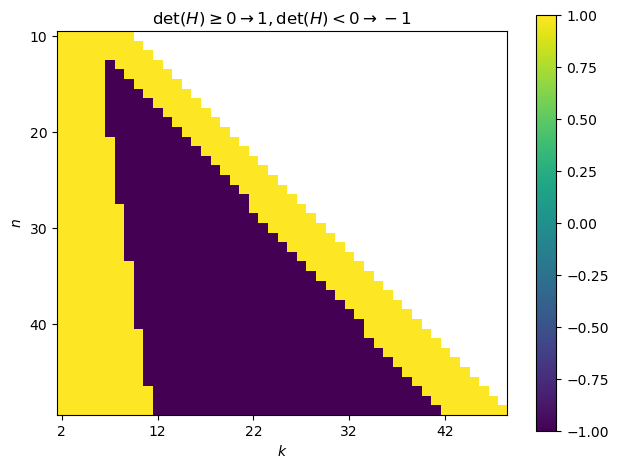

In [45]:
import matplotlib.pyplot as plt

mu0_tr = mus_tr[0]
system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
print(system_params)
detnk = []
for n in range(10,50):
    detn = []
    for k in range(2,n):
        det = det_Hessian_Pnk(system_params, conv_params, n, k)
        # detn.append(det)
        if det < 0:
            print(n, k, det)
            detn.append(-1)
        else:
            z = 0
            detn.append(1)
    detn += [np.nan for i in range(49-n)]
    # print(len(detn))
    detnk.append(np.asarray(detn))
detnk = np.asarray(detnk)
plt.xticks(np.arange(0, 50, 10), labels=[str(i+2) for i in range(0, 50, 10)])
plt.yticks(np.arange(0, 50, 10), labels=[str(i+10) for i in range(0, 50, 10)])
plt.xlabel('$k$')
plt.ylabel('$n$')
plt.title('$\det(H)$')
plt.title(r'$\det(H)\geq0\rightarrow1,\det(H)<0\rightarrow-1$')
plt.imshow(detnk)
cb = plt.colorbar()
plt.tight_layout()
plt.show()
        
# print(cnt, cnt1)

In [40]:
mus_tr_TNKs = []
for mu0_tr in mus_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print('System parameters:',system_params)
    Tnk = solve_nk_scipy(system_params, conv_params)
    T,n,k = Tnk
    print(f'dk={estimated_derivative_k(system_params, conv_params, n, k)},dn={estimated_derivative_n(system_params, conv_params, n, k)}')
    
    # print(estimated_derivative_k(system_params, conv_params, n, k-1), estimated_derivative_k(system_params, conv_params, n, k+1))
    mus_tr_TNKs.append(Tnk)
    
optimal_ns = np.asarray([Tnk[1] for Tnk in mus_tr_TNKs])
optimal_ks = np.asarray([Tnk[2] for Tnk in mus_tr_TNKs])
r = optimal_ks / optimal_ns

# 看上去还不够优啊？

System parameters: (100000000.0, 1e-09, 1000000000.0, 1e-09, 100000000.0, 1e-09)
n*,k*=[15.35419025  7.27048655]   T*=2.0395063623165752
dk=8.368804100530616,dn=9.067794258799111e-07
System parameters: (200000000.0, 1e-09, 1000000000.0, 1e-09, 200000000.0, 1e-09)
n*,k*=[14.98330184  7.61519782]   T*=1.8570860264942717
dk=5.341272934182145,dn=1.1900928371250119e-07
System parameters: (300000000.0, 1e-09, 1000000000.0, 1e-09, 300000000.0, 1e-09)
n*,k*=[14.85136138  7.75228355]   T*=1.7948600014753557
dk=4.461949968052203,dn=4.814538666290946e-06
System parameters: (400000000.0, 1e-09, 1000000000.0, 1e-09, 400000000.0, 1e-09)
n*,k*=[14.78288074  7.82650504]   T*=1.7634272662732928
dk=4.046579901710261,dn=1.0938220642298102e-06
System parameters: (500000000.0, 1e-09, 1000000000.0, 1e-09, 500000000.0, 1e-09)
n*,k*=[14.74158319  7.87317558]   T*=1.744456392284206
dk=3.805612170345293,dn=1.652329803501773e-06
System parameters: (600000000.0, 1e-09, 1000000000.0, 1e-09, 600000000.0, 1e-09)
n*,

c:\Users\SUST\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method CG cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
c:\Users\SUST\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:569: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [41]:
h1,h2,h3,h4,h5,h6,h7,h8 = 0.0002981888, 0.033511833600000006, 0.033397145600000004, 0.025690112, 3.6993761280000004, 0.00114688, 0.25690112, 3.6993761280000004
n, k = 3, 2
z = h1-h4/k**2-h6/(n-k)**2+h7*(n-2*k)/(k*(n-k))-np.log(n/(n-k))/k**2*h7-h8/(n*(n-k)**2)
z

-1.4394058370511502